In [1]:
using TVC, DifferentialEquations, SCPToolbox, Plots

# Specify Parameters

In [2]:
veh = RocketParameters()
atmos = Atmosphere()
traj = RocketTrajectoryParameters();

mdl = RocketProblem(veh, atmos, traj)

RocketProblem
  veh: RocketParameters{Float64, LinearAlgebra.Diagonal{Float64, Vector{Float64}}}
  atmos: Atmosphere
  traj: RocketTrajectoryParameters{Float64}


In [3]:
servoΔt = 0.02 # Servo step rate
x_0 = [traj.r0; traj.v0; traj.q0; traj.ω0][[veh.id_r; veh.id_v; veh.id_quat; veh.id_ω]];

# Solve Optimal Trajectory

In [4]:
solution = solveProblem(mdl);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 1e-01 | 0e+00 | 6e-09 | 9.26e+00  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.10  | 0.40  | 0.16 


2  | ALMOST_O | 5e-04 | 0e+00 | 8e-09 | 3.58e-01  | 96.13     | 1e-02 | 3e-01 | 3e-02 | 4e-02 | T   | 0.08  | 0.28  | 0.03 


3  | ALMOST_O | 3e-04 | 0e+00 | 1e-08 | 2.82e-01  | 21.43     | 9e-03 | 3e-01 | 7e-04 | 1e-02 | T   | 0.05  | 0.28  | 0.00 


4  | ALMOST_O | 8e-06 | 0e+00 | 3e-08 | 2.79e-01  | 0.86      | 2e-03 | 2e-01 | 4e-05 | 2e-03 | T   | 0.03  | 0.19  | 0.00 


5  | ALMOST_O | 5e-06 | 0e+00 | 2e-08 | 2.79e-01  | -0.02     | 1e-03 | 2e-01 | 3e-05 | 1e-03 | T   | 0.08  | 0.21  | 0.00 


# Specify Controller

In [5]:
function control(t, Rocket, solution) # Get TVC from optimal solution
    if 0 ≤ t ≤ Rocket.BurnTime
        return vcat(sample(solution.xc, t / Rocket.BurnTime)[Rocket.id_T] * Rocket.Thrust(t), sample(solution.uc, t / Rocket.BurnTime)[Rocket.id_roll])
    else
        return zeros(4)
    end
end

control (generic function with 1 method)

In [6]:
function control(t, Rocket, solution, servoΔt) # discretise TVC based on servo step rate
    td = t - t % servoΔt
    if 0 ≤ t ≤ Rocket.BurnTime
        return vcat(sample(solution.xc, td / Rocket.BurnTime)[Rocket.id_T] * Rocket.Thrust(t), sample(solution.uc, t / Rocket.BurnTime)[Rocket.id_roll])
    else
        return zeros(4)
    end
end

control (generic function with 2 methods)

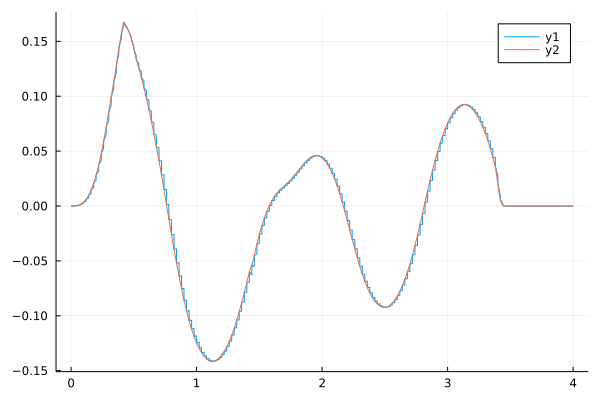

In [7]:
t = 0:0.001:4

plot(t, mapreduce(t -> control(t, veh, solution, servoΔt), hcat, t)[1, :])
plot!(t, mapreduce(t -> control(t, veh, solution), hcat, t)[1, :])

# Simulate controller using optimal trajectory

## Continuous Controller

In [8]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=MotorIgnitionTime, solution=solution, Control=t -> control(motorTime(t, MotorIgnitionTime), veh, solution))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

retcode: Terminated
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 680-element Vector{Float64}:
 0.0
 0.03230153508479973
 0.186116941409862
 0.8730879273970481
 1.0254828619456986
 1.19347396696222
 1.235811679846475
 1.3154596637827252
 1.3189372171255542
 1.3229378225344717
 ⋮
 4.752840988571112
 4.756162651342216
 4.759844053086695
 4.764103317399303
 4.769384124550509
 4.771926515972923
 4.774203877406673
 4.7743298832479555
 4.7743298832479555
u: 680-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.1292061403392, -4.096904605254399, 29.994883972011525, 4.0, -3.0, -0.3167668642628626, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.74446776563945, -4.558350824229586, 29.830152794786738, 4.0, -3.0, -1.8251665370906782, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [23.492351709588192, -6.619263782191145, 26.26231550811114, 4.0, -3.0, -8.56199039284494, 1.0, 0.0, 0.0, 0.

1.324640472775682
3.4496894104722733


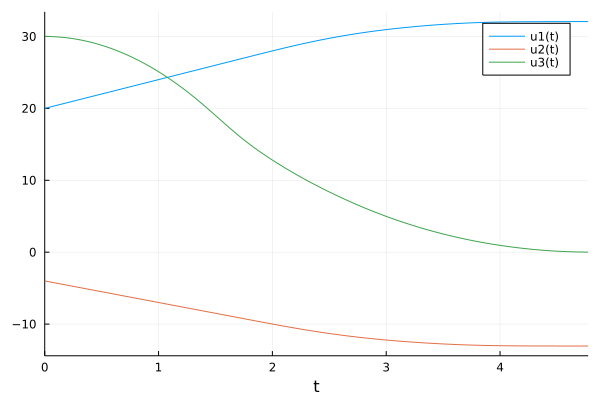

In [9]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)
Plots.plot(sol, vars=1:3)

## Discrete Controller

In [32]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=MotorIgnitionTime, solution=solution, Control=t -> control(motorTime(t, MotorIgnitionTime), veh, solution, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-12, abstol=1e-12, callback=cb)

retcode: Terminated
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 7290-element Vector{Float64}:
 0.0
 0.024892152865661963
 0.06478457301866296
 0.11933080239898997
 0.18842758205146456
 0.27781747975138227
 0.39049156605187785
 0.5414246846399371
 0.7434362949539135
 1.0098787488587688
 ⋮
 4.693953030819761
 4.6947914147260565
 4.695641309257606
 4.696695451998928
 4.697668491466201
 4.69869744991023
 4.699706512017181
 4.700690673677927
 4.700690673677927
u: 7290-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.099568611462647, -4.0746764585969855, 29.996961833950557, 4.0, -3.0, -0.24410633072366378, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.259138292074653, -4.1943537190559885, 29.979420738322663, 4.0, -3.0, -0.6353136476975701, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.477323209595962, -4.35799240719697, 29.930178092252934, 4.0, -3.0, -1.1702243946843842,

In [33]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)

1.324640472775682
3.3760502009022444


In [34]:
function controlTest(t, Rocket, solution, servoΔt) # discretise TVC based on servo step rate
    td = t - t % servoΔt
    if 0 ≤ td ≤ Rocket.BurnTime
        return sample(solution.xc, td / Rocket.BurnTime)[Rocket.id_T]
    else
        return zeros(3)
    end
end

controlTest (generic function with 1 method)

In [58]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, MotorIgnitionTime + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=MotorIgnitionTime, solution=solution, Control=controlTest(motorTime(0, MotorIgnitionTime), veh, solution, servoΔt))

prob = ODEProblem(TVC.Utils.fTest!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

function actuator!(integrator)
    tₘ = motorTime(integrator.t, integrator.p.MotorIgnitionTime)
    integrator.p.Control[:] = controlTest(tₘ + 0.001, integrator.p.veh, solution, servoΔt) # update array in immutable struct
end

tstops = p.MotorIgnitionTime:servoΔt:tspan[end]
pcb = PresetTimeCallback(tstops, actuator!) # Update control every servoΔt seconds, using actuator! function

saved_values = SavedValues(Float64, AbstractVector{Float64})

scb = SavingCallback((u, t, integrator) -> copy(integrator.p.Control), saved_values, save_everystep = true) #saveat=tstops)

cbs = CallbackSet(cb, pcb, scb);

sol = DifferentialEquations.solve(prob, reltol=1e-12, abstol=1e-12, callback=cbs)

retcode: Terminated
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 4214-element Vector{Float64}:
 0.0
 0.024892152865661963
 0.06478457301866296
 0.11933080239898997
 0.18842758205146456
 0.27781747975138227
 0.39049156605187785
 0.5414246846399371
 0.7434362949539135
 1.0098787488587688
 ⋮
 4.693719644245875
 4.694718593861907
 4.695717949216562
 4.696717721934023
 4.697717769070958
 4.698717925659157
 4.699718075120224
 4.700690674350232
 4.700690674350232
u: 4214-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.099568611462647, -4.0746764585969855, 29.996961833950557, 4.0, -3.0, -0.24410633072366378, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.259138292074653, -4.1943537190559885, 29.979420738322663, 4.0, -3.0, -0.6353136476975701, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.477323209595962, -4.35799240719697, 29.930178092252934, 4.0, -3.0, -1.1702243946843842,

In [59]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)

1.324640472775682
3.37605020157455


In [60]:
Thrust = zeros(length(saved_values.t), 3)
for (i, t) in enumerate(saved_values.t)
    Thrust[i, :] = saved_values.saveval[i] * veh.Thrust(motorTime(t, MotorIgnitionTime))
end

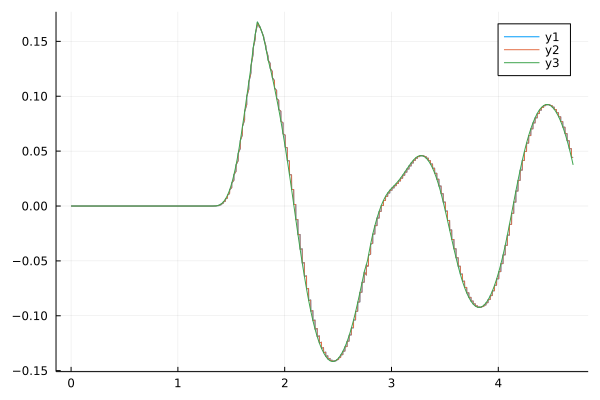

In [61]:
plot(saved_values.t, Thrust[:, 1])
plot!(saved_values.t, mapreduce(t -> control(motorTime(t, MotorIgnitionTime), veh, solution, servoΔt), hcat, saved_values.t)[1, :])
plot!(saved_values.t, mapreduce(t -> control(motorTime(t, MotorIgnitionTime), veh, solution), hcat, saved_values.t)[1, :])

In [15]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, MotorIgnitionTime + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=MotorIgnitionTime, solution=solution, Control=control(motorTime(0, MotorIgnitionTime), veh, solution, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

function actuator!(integrator)
    tₘ = motorTime(integrator.t, integrator.p.MotorIgnitionTime)
    integrator.p.Control[:] = control(tₘ, integrator.p.veh, solution) # update array in immutable struct
end

pcb = PeriodicCallback(actuator!, servoΔt) # Update control every servoΔt seconds, using actuator! function

cbs = CallbackSet(cb, pcb);

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cbs)

retcode: Terminated
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 848-element Vector{Float64}:
 0.0
 0.02
 0.02
 0.04
 0.04
 0.06
 0.06
 0.08
 0.08
 0.1
 ⋮
 4.22
 4.24
 4.24
 4.26
 4.26
 4.28
 4.28
 4.286868043637005
 4.286868043637005
u: 848-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.08, -4.06, 29.998038688481557, 4.0, -3.0, -0.19613115186423208, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.08, -4.06, 29.998038688481557, 4.0, -3.0, -0.19613115186423208, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.159999999999997, -4.119999999999999, 29.992154753923817, 4.0, -3.0, -0.392262303970119, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.159999999999997, -4.119999999999999, 29.992154753923817, 4.0, -3.0, -0.392262303970119, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.239999999999995, -4.179999999999999, 29.982348196319528, 4.0, -3.0, -0.5883934565593157, 1.0, 0.0, 0.0, 0.0, 0.

In [16]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)

1.324640472775682
2.962227570861323


In [17]:
MotorIgnitionTime = solution.p[veh.id_tcoast]

tspan = (0, MotorIgnitionTime + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=MotorIgnitionTime, solution=solution, Control=control(motorTime(0, MotorIgnitionTime), veh, solution, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p) 

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

condition(x,t,integrator) = integrator.t - integrator.p.MotorIgnitionTime # when zero halt integration
cb2 = ContinuousCallback(condition, terminate!) # when going upwards do nothing

function actuator!(integrator)
    tₘ = motorTime(integrator.t, integrator.p.MotorIgnitionTime)
    integrator.p.Control[:] = control(tₘ, integrator.p.veh, solution, servoΔt) # update array in immutable struct
end

pcb = PeriodicCallback(actuator!, servoΔt) # Update control every servoΔt seconds, using actuator! function

cbs = CallbackSet(cb, pcb);

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cbs)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 2008-element Vector{Float64}:
  0.0
  0.02
  0.02
  0.04
  0.04
  0.06
  0.06
  0.08
  0.08
  0.1
  ⋮
 14.700000000000001
 14.700000000000001
 14.72
 14.72
 14.74
 14.74
 14.76
 14.76
 14.774640472775683
u: 2008-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.08, -4.06, 29.998038688481557, 4.0, -3.0, -0.19613115186423208, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.08, -4.06, 29.998038688481557, 4.0, -3.0, -0.19613115186423208, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.159999999999997, -4.119999999999999, 29.992154753923817, 4.0, -3.0, -0.392262303970119, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.159999999999997, -4.119999999999999, 29.992154753923817, 4.0, -3.0, -0.392262303970119, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.239999999999995, -4.179999999999999, 29.982348196319528, 4.0, -3.0, -0.58839345

In [18]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)

1.324640472775682
13.450000000000001


# MPC Controller

In [19]:
function mpc!(integrator)
    traj = integrator.p.traj
    veh = integrator.p.veh
    atmos = integrator.p.atmos

    r = x[veh.id_r]
    v = x[veh.id_v]
    quat = x[veh.id_quat]
    ω = x[veh.id_ω]

    if integrator.t >= integrator.p.MotorIgnitionTime
        traj = RocketTrajectoryParameters(r0=r, v0=v, q0=q, ω0=ω, t0=integrator.t - integrator.p.MotorIgnitionTime, MotorFired=true)
    else
        traj = RocketTrajectoryParameters(r0=r, v0=v, q0=q, ω0=ω)
    end

    mdl = RocketProblem(veh, atmos, traj)
    integrator.p.solution = solve(mdl)

    if not traj.MotorFired
        integrator.p.MotorIgnitionTime = integrator.t + integrator.p.solution.p[veh.id_tcoast]
    end
end

pcb = PeriodicCallback(actuator!, servoΔt)
pcb2 = PeriodicCallback(mpc!, 0.5);

In [20]:
tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=solution.p[veh.id_tcoast], solution=solution, Control=actuator(-solution.p[veh.id_tcoast], veh, solution, servoΔt))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

cbs = CallbackSet(cb, pcb);

UndefVarError: UndefVarError: actuator not defined

In [21]:
sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cbs)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 2008-element Vector{Float64}:
  0.0
  0.02
  0.02
  0.04
  0.04
  0.06
  0.06
  0.08
  0.08
  0.1
  ⋮
 14.700000000000001
 14.700000000000001
 14.72
 14.72
 14.74
 14.74
 14.76
 14.76
 14.774640472775683
u: 2008-element Vector{Vector{Float64}}:
 [20.0, -4.0, 30.0, 4.0, -3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.08, -4.06, 29.998038688481557, 4.0, -3.0, -0.19613115186423208, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.08, -4.06, 29.998038688481557, 4.0, -3.0, -0.19613115186423208, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.159999999999997, -4.119999999999999, 29.992154753923817, 4.0, -3.0, -0.392262303970119, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.159999999999997, -4.119999999999999, 29.992154753923817, 4.0, -3.0, -0.392262303970119, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [20.239999999999995, -4.179999999999999, 29.982348196319528, 4.0, -3.0, -0.58839345

1.324640472775682
13.450000000000001


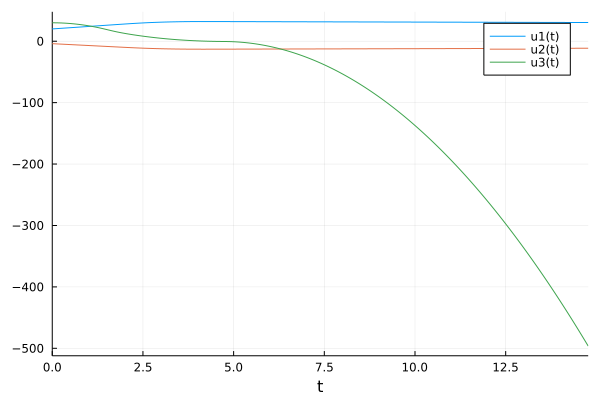

In [22]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - sol.prob.p.MotorIgnitionTime)
Plots.plot(sol, vars=1:3)

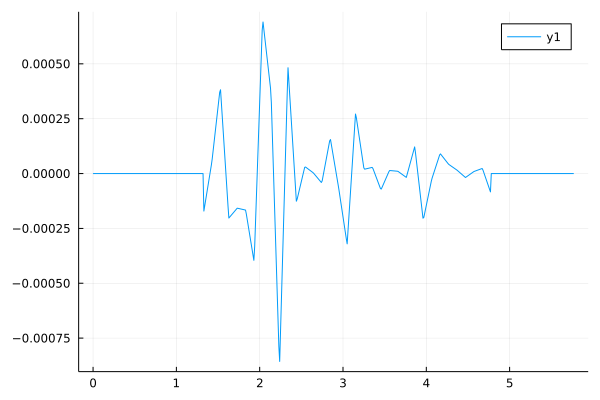

In [23]:
t = 0:0.01:veh.BurnTime+solution.p[veh.id_tcoast]+1.
controlPlot = mapreduce(t -> control(t-solution.p[veh.id_tcoast], veh, solution), hcat, t)[4, :]
plot(t, controlPlot)

In [24]:
tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, MotorIgnitionTime=solution.p[veh.id_tcoast], solution=solution, Control=t -> control(motorTime(t), veh, solution))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-10, abstol=1e-10, callback=cb)

MethodError: MethodError: no method matching motorTime(::Float64)
Closest candidates are:
  motorTime(::Any, !Matched::RocketProblem) at e:\Code\TVC\TVC.jl\src\Guidance\PlotSave.jl:18
  motorTime(::Any, !Matched::Any) at e:\Code\TVC\TVC.jl\src\Utils\Dynamics.jl:86

In [25]:
solution.xd[:, 1]

19-element Vector{Float64}:
  25.298561891102736
  -7.973921418326995
  21.39635264076526
   4.000000001001425
  -3.0000000006080825
 -12.990163084516581
   0.9999999017664793
  -4.4962389367242395e-10
  -3.114937197068457e-10
   2.8199664825478976e-14
  -1.1762892881961307e-9
  -1.7981154343260641e-9
   3.552713678800501e-15
   5.602018182671031e-9
  -2.314919811396976e-9
   1.0000000175474164
   4.352652904771048e-9
  -1.5669274766594299e-9
   4.844169509965468e-9

In [26]:
sol(solution.p[veh.id_tcoast])

13-element Vector{Float64}:
  25.298561891102615
  -7.973921418327062
  21.39634824041534
   4.0
  -3.0
 -12.990174785608815
   1.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

1.324640472775682
13.450000000000001


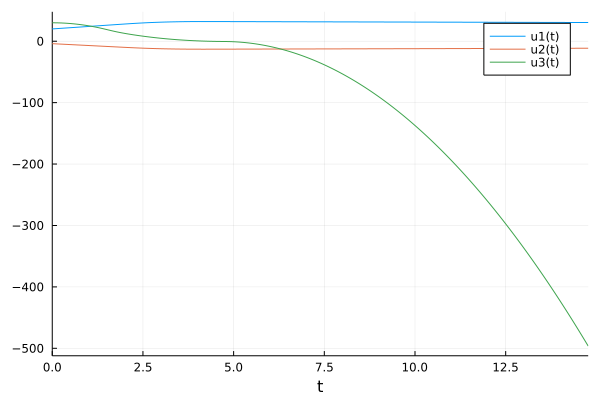

In [27]:
println(sol.prob.p.MotorIgnitionTime)
println(sol.t[end] - solution.p[veh.id_tcoast])
Plots.plot(sol, vars=1:3)

In [28]:
tspan = (0, solution.p[veh.id_tcoast] + veh.BurnTime + 10.0)
p = (veh=veh, atmos=atmos, wind=randn(3) * 5, traj=traj, solution=solution, Control=t -> control(t - solution.p[veh.id_tcoast], veh, solution))

prob = ODEProblem(f!, x_0, tspan, p)

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-10, abstol=1e-10, callback=cb)

ErrorException: type NamedTuple has no field MotorIgnitionTime

In [29]:
sol.t[end] - solution.p[veh.id_tcoast]

13.450000000000001

In [30]:
using TVC.Utils, LinearAlgebra

function ftest!(dx, x, p, t)
    r = x[1:3]
    height = r[3]
    v = x[4:6]
    quat = x[7:10]
    ω = x[11:13]

    rocket, atmos, solution, wind = p

    if 0 ≤ t ≤ rocket.BurnTime
        T = sample(solution.xc, t / rocket.BurnTime)[veh.id_T] # if false, false
        roll = sample(solution.uc, t / rocket.BurnTime)[veh.id_roll]
    else
        T = zeros(3)
        roll = 0.
    end



    dx[1:3] = v
    dx[4:6] = atmos.g(height) + TVC.Utils.rotate(quat, T) * rocket.Acceleration(t)
    dx[7:10] = 1/2 * TVC.Utils.quatL(quat) * [0; ω]
    dx[11:13] = rocket.InertiaTensor \ (cross(rocket.MomentArm(t), T) * rocket.Thrust(t) + [0; 0; roll] - cross(ω, rocket.InertiaTensor * ω))
end

prob = ODEProblem(f!, x_0, (-solution.p[1], veh.BurnTime + 1.0), (veh, atmos, solution, randn(3) * 5))

condition(x,t,integrator) = x[3] # when zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

println(sol.t[end])
Plots.plot(sol, vars=1:3)

ErrorException: type Tuple has no field veh